In [1]:
!pip install -q -U kaggle_environments

In [2]:
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

In [3]:
# Define playing strategies for RPS

#0 - rock
#1 - paper
#2 - scissors

winner_dict = {0: 1, 1: 2, 2: 0} # paper wins rock, scissors win paper, rock wins scissors


#1 rock -> paper -> scissors -> rock -> paper -> scissors -> ...

def round_robin(observation, configuration):
    return observation.step%3


#2 randomly choses one of 3 options

def random_choice(observation, configuration):
    return random.randint(0,2)


#3 rock -> paper -> rock -> paper -> rock -> paper -> rock -> paper -> ...

def rock_or_paper(observation, configuration):
    return observation.step%2


#4 choose action that wins opponent's action on the previous step

def win_prev_opponent_step(observation, configuration):
    if observation.step==0:
        return random.randint(0,2)
    global winner_dict
    return winner_dict[observation.lastOpponentAction]


#5 collects opponent's action history and act to winn the most popular action of the opponent

opponents_favorite_list = []

def win_opponents_favorite(observation, configuration):
    global opponents_favorite_list
    if observation.step==0:
        opponents_favorite_list = [0, 0, 0]
    else:
        opponents_favorite_list[observation.lastOpponentAction]+=1
    max_frequency  = max(opponents_favorite_list)
    prediction = opponents_favorite_list.index(max_frequency)
    return winner_dict[prediction]

#6 3 rocks -> 2 scissors -> 1 paper -> 3 rocks -> 2 scissors -> 1 paper -> ... with the random 1st action

r3s2p1_list = []

def r3s2p1(observation, configuration):
    global r3s2p1_list
    if observation.step == 0:
        r3s2p1_list = [0, 0, 0, 2, 2, 1] * (configuration.episodeSteps // 6 + 2)
        result = random.randint(0,2) 
        r3s2p1_list = r3s2p1_list[r3s2p1_list.index(result):]
    else:
        result = r3s2p1_list[observation.step]
    return result


#7 Random walk imitation to choose the next action

random_walk_previous = 0

def random_walk(observation, configuration):
    global random_walk_previous
    if observation.step == 0:
        result = random.randint(0,2)
    else:
        result = (random_walk_previous + random.randint(0,2)) % 3
    random_walk_previous = result
    return result

same_choice_int = 0


#8 Randomly choose action and keep using it untill the end of episode

def same_choice(observation, configuration):
    global same_choice_int
    if observation.step == 0:
        same_choice_int = random.randint(0,2)
    return same_choice_int


#9 Choose the action that wins my own previous step

win_my_prev_step_int = 0

def win_my_prev_step(observation, configuration):
    global win_my_prev_step_int
    if observation.step == 0:
        result = random.randint(0,2)
    else:
        result = winner_dict[win_my_prev_step_int]
    win_my_prev_step_int = result
    return result


#10 Choose the action that wins the action that wins my own previous step

win_win_my_prev_step_int = 0

def win_win_my_prev_step(observation, configuration):
    global win_win_my_prev_step_int
    if observation.step == 0:
        result = random.randint(0,2)
    else:
        result = winner_dict[winner_dict[win_my_prev_step_int]]
    win_win_my_prev_step_int = result
    return result


#11 Randomly choose the next action with low likelihood of rock

def avoid_rock(observation, configuration):
    return random.choices([0, 1, 2], [10,45,45], k=1)[0]


#12 Randomly choose the next action with the strong preference of rock

def rock_fan(observation, configuration):
    return random.choices([0, 1, 2], [90,5,5], k=1)[0]


#13 Randomly choose the next action with the a bit higher preference of rock

def rocky_random(observation, configuration):
    return random.choices([0, 1, 2], [40,30,30], k=1)[0]
    

In [4]:
# Give names to agents based on their strategy

agents = {
    "round_robin": round_robin,
    "random_choice": random_choice,
    "rock_or_paper": rock_or_paper,
    "win_prev_opponent_step": win_prev_opponent_step,
    "win_opponents_favorite": win_opponents_favorite,
    "r3s2p1": r3s2p1,
    "random_walk": random_walk,
    "same_choice": same_choice,
    "win_my_prev_step": win_my_prev_step,
    "win_win_my_prev_step": win_win_my_prev_step,
    "avoid_rock": avoid_rock,
    "rock_fan": rock_fan,
    "rocky_random": rocky_random
}

print(f"Created {len(agents)} agents.")

Created 13 agents.


In [5]:
# Calculate pairs for the RPS Cup competition (each agents will play with all other agents)

agents_list = list(agents.keys())

pairs = []

for player_1 in agents_list:
    next_player_index = agents_list.index(player_1) + 1
    for player_2 in agents_list[next_player_index :]:
        pairs.append([player_1, player_2])

In [11]:
# Define function that will calculate the result of the player vs competitor
# and return it in a list as [player, competitor, player's score]

def pair_cup_results(pair):
    results = evaluate("rps", 
                       agents = [agents[pair[0]], agents[pair[1]]],
                       configuration = {"episodeSteps": 100},
                       num_episodes = 4 # choose more episodes to get more reliable results
                        )
    player_1_sum = sum([x[0] for x in results])
    return [pair[0], pair[1], player_1_sum]

In [12]:
# Calculate RPS Cup results for the pairs in a list

rps_cup_results = [pair_cup_results(pair) for pair in pairs]

# Append results for the competitors (plyers_2) vs players (player_1)

rps_cup_results.extend([[x[1], x[0], -x[2]] for x in rps_cup_results])

Text(0.5, 1.0, 'RPS CUP player vs competitor results')

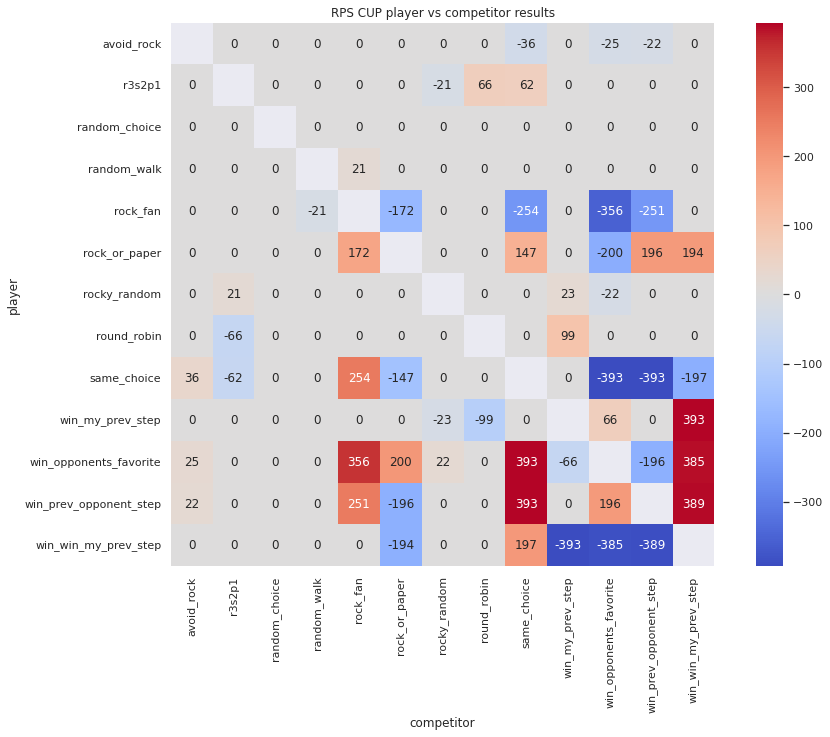

In [13]:
# Visualize PRS Cup results as heatmap

rps_cup_df = pd.DataFrame(rps_cup_results, columns = ['player', 'competitor','result'])
rps_cup_df = rps_cup_df.pivot(index = 'player', columns = 'competitor', values = 'result')

sns.set(rc = {"figure.figsize": (15, 10)})

ax = sns.heatmap(rps_cup_df,
                cmap = "coolwarm",
                square = True,
                annot = True,
                fmt = ".0f",
                )

plt.title("RPS CUP player vs competitor results")

In [14]:
# Print medal winners

rps_cup_df['cup_total'] = rps_cup_df.sum(axis=1)

medals = {0: 'Gold', 1: 'Silver', 2: 'Bronze'}
place = 0

for index, row in rps_cup_df[['cup_total']].sort_values('cup_total', ascending = False).head(3).iterrows():
    print(f'{medals[place]} - {index} - score: {int(row[0])}')
    place += 1

Gold - win_opponents_favorite - score: 1119
Silver - win_prev_opponent_step - score: 1055
Bronze - rock_or_paper - score: 509
